# Spin Qubit Pulse Sequences with the HDAWG

This notebook shows you how to use pulse sequences with an HDAWG to realize various experiments. While the sequences are mostly general, they are adapted to those typically used for spin qubits by adding the gate pulsing to control between Coulomb and spin blockade.

# General Imports

In [1]:
%config IPCompleter.greedy=True

# import matplotlib.pyplot as plt
import numpy as np
import time
import zhinst.core
import laboneq
from laboneq.simple import *

import helpers
from PyDAQmx.DAQmxFunctions import *
from PyDAQmx.DAQmxConstants import *
import matplotlib.pyplot as plt
#install_token("LabOneQ.AllQuantumInOne.")
DO_EMULATION = False # run in emulation mode by default

print(laboneq.__version__)

2.11.0


# Sampling card setup

In [2]:
# Sampling card setup
class MultiChannelAnalogInput(object):
    """Class to create a multi-channel analog input
    
    Usage: AI = MultiChannelInput(physicalChannel)
        physicalChannel: a string or a list of strings
    optional parameter: limit: tuple or list of tuples, the AI limit values
                        reset: Boolean
    Methods:
        read(name), return the value of the input name
        readAll(), return a dictionary name:value
    """
    def __init__(self,physicalChannel, limit = None, reset = False):
        self.taskHandle = None
        if type(physicalChannel) == type(""):
            self.physicalChannel = [physicalChannel]
        else:
            self.physicalChannel  =physicalChannel
        self.nCh = physicalChannel.__len__()
        if limit is None:
            self.limit = dict([(name, (-10.0,10.0)) for name in self.physicalChannel])
        elif type(limit) == tuple:
            self.limit = dict([(name, limit) for name in self.physicalChannel])
        else:
            self.limit = dict([(name, limit[i]) for  i,name in enumerate(self.physicalChannel)])           
        if reset:
            DAQmxResetDevice(physicalChannel[0].split('/')[0] )
            
    def configure(self, address , rate=10000., nSample=1E3, trig=None, trigSlopePositive=True, trigLevel=0.0):
        # Create one task handle for all
        self.rate = rate
        self.nSample = nSample
        self.taskHandle = TaskHandle(0)
        DAQmxCreateTask("",byref(self.taskHandle))
        for name in self.physicalChannel:
            DAQmxCreateAIVoltageChan(self.taskHandle,name,"",DAQmx_Val_RSE,
                                     self.limit[name][0],self.limit[name][1],
                                     DAQmx_Val_Volts,None)
        print(nSample)
        DAQmxCfgSampClkTiming(self.taskHandle,"",float(rate),DAQmx_Val_Rising,DAQmx_Val_FiniteSamps,int(nSample))
        if trig is None:
            DAQmxDisableStartTrig(self.taskHandle)
        elif str(trig).startswith('%s/port' % address):
            # digital trigger
            trigEdge = DAQmx_Val_Rising if trigSlopePositive else DAQmx_Val_Falling 
            DAQmxCfgDigEdgeStartTrig(self.taskHandle,str(trig),trigEdge)
        else:
            # analog trigger
            trigSlope = DAQmx_Val_RisingSlope if trigSlopePositive else DAQmx_Val_FallingSlope 
            DAQmxCfgAnlgEdgeStartTrig(self.taskHandle,str(trig),trigSlope,trigLevel)

    def readAll(self):
        DAQmxStartTask(self.taskHandle)
        data = np.zeros((self.nCh*self.nSample,), dtype=np.float64)
#        data = AI_data_type()
        read = int32()
        timeout = 100.0
        DAQmxReadAnalogF64(self.taskHandle,self.nSample,timeout,DAQmx_Val_GroupByChannel,data,len(data),byref(read),None)
        DAQmxStopTask(self.taskHandle)
        # output data as dict
        dOut = dict()
        for n, name in enumerate(self.physicalChannel):
            dOut[name] = data[(n*self.nSample):((n+1)*self.nSample)]
        return dOut
    
    def closeAll(self):
        # close all channels
        if self.taskHandle is None:
            return
        DAQmxStopTask(self.taskHandle)
        DAQmxClearTask(self.taskHandle)  

def getTriggerSource(trigSource, trigLevel,lChName,lChDig): 
    print(trigSource)
    if trigSource == 'Immediate':
        trigSource = None
        trigSlopePositive = True
        trigLevel = 0.0
    else:
        # trig from channel
        iTrig = trigSource
        if iTrig < len(lChName):
            trigSource = lChName[iTrig]
        else:
            trigSource = lChDig[iTrig-len(lChName)]

        trigSlopePositive = True
    return trigSource, trigSlopePositive ,trigLevel

In [3]:
limit = []
lCh = []
nCh = 8
lTrace = [np.array([])]*nCh
# dt = 1.0
mAI = None
address = 'Dev1'

lChName = [("%s/ai%d" % (address, n))
                    for n in range(nCh)]

lChDig = [("%s/port0/line%d" % (address, n))
                for n in range(nCh)]

# lChDig = [("/%s/pfi0/p1.0" % (address))]

lSignalName = [('Ch%d: Data' % (n+1)) for n in range(nCh)]

chEnable = [False] * 8
chEnable[0] = True
chEnable[2] = True
chEnable[3] = True
chEnable[4] = True 
chEnable[6] = True
for n in range(nCh):
    s = 'Ch%d: ' % (n+1)
    # check if enabled
    if chEnable[n]:  # Enable is turn or false
        limit.append([-10, 10])  # some value [-10 , 10]
        lCh.append(lChName[n])

# get config
nSample = int(1e4)
rate = float(10e3)
dt = 1.0/rate


trigSource = 'Immediate' # trigSource = 'Immediate' # 'Immediate' or a number between 0-7 (channel)
trigLevel = 0.5
trigSource, trigSlopePositive ,trigLevel = getTriggerSource(trigSource, trigLevel,lChName,lChDig)

Immediate


# Device Setup

Device specific parameters are still required.

## Create device setup

In [4]:
descriptor="""
instrument_list:
  HDAWG:
  - address: DEV8721
    uid: device_hdawg
    interface: usb
connections:
  device_hdawg:
    - rf_signal: q0/fg8_line
      ports: [SIGOUTS/0]
    - rf_signal: q0/fg9_line
      ports: [SIGOUTS/1]
"""
#Change back to to SIGOUTS/2 and SIGOUTS/3
#And change fg8 and fg9
device_setup = DeviceSetup.from_descriptor(
    descriptor,
    server_host="127.0.0.1",
    server_port="8004",
    setup_name="ZI_HDAWG",
)

c:\Users\B15measure2\anaconda3\envs\laboneq\lib\site-packages\laboneq\dsl\device\_device_setup_generator.py:1104: FutureWarning: 'instrument_list' section is deprecated in setup descriptor, use 'instruments' instead.
  warnings.warn(


# S-T readout

## Define parameters for experiment

In [21]:
points_map={
    'level1': [0.2, -0],
    'level2': [-0, 0],}


times_map = {'pulse_time': 10e-3,
             'trigger_time': 1e-3}

In [22]:
# define pulse shapes
@pulse_library.register_pulse_functional
def ramp(x,start=0,stop=1 , **_):
    pulse=start+ (stop-start)*(x+1)/2 # Time normalized to (-1,1)
    return pulse



compress_level_pulse_level1_gate1=pulse_library.const(uid="compress_levell1g1",length=times_map['pulse_time'],amplitude=points_map['level1'][0],can_compress=True)
compress_level_pulse_level1_gate2=pulse_library.const(uid="compress_levell1g2",length=times_map['pulse_time'],amplitude=points_map['level1'][1],can_compress=True)
compress_level_pulse_level2_gate1=pulse_library.const(uid="compress_levell2g1",length=times_map['pulse_time'],amplitude=points_map['level2'][0],can_compress=True)
compress_level_pulse_level2_gate2=pulse_library.const(uid="compress_levell2g2",length=times_map['pulse_time'],amplitude=points_map['level2'][1],can_compress=True)


In [23]:
## Create Experiment
exp = Experiment(
    "Singlet-triplet qubit example",
    signals=[
        #ExperimentSignal("gate1"),
        #ExperimentSignal("gate2"),
        ExperimentSignal("gate3"),
        ExperimentSignal("gate4"),
    ],
)

# define experiment
NUM_REP = 5

with exp.acquire_loop_rt(
    uid=("shots"), count=NUM_REP, averaging_mode=AveragingMode.SEQUENTIAL
):
    # with exp.section(
    #     uid="outer_trigger", 
    #     length=times_map['trigger_time'],
    #     alignment=SectionAlignment.LEFT):
    #     exp.reserve(signal="gate1")

    with exp.section(
        uid=("level1"),
        length=times_map['pulse_time'], 
        #trigger={"gate1": {"state": 1}}, 
        alignment=SectionAlignment.LEFT,
    ):
        #exp.play(signal="gate1", pulse=compress_level_pulse, amplitude=points_map['level1'][1])
        #exp.play(signal="gate2", pulse=compress_level_pulse, amplitude=points_map['level1'][1])
        exp.play(signal="gate3", pulse=compress_level_pulse_level1_gate1)
        exp.play(signal="gate4", pulse=compress_level_pulse_level1_gate2)    
    with exp.section(
        uid=("level2"),
        length=times_map['pulse_time'], 
        alignment=SectionAlignment.LEFT,
    ):
        #exp.play(signal="gate1", pulse=compress_level_pulse, amplitude=points_map['level2'][1])
        #exp.play(signal="gate2", pulse=compress_level_pulse, amplitude=points_map['level2'][1])
        exp.play(signal="gate3", pulse=compress_level_pulse_level2_gate1)
        exp.play(signal="gate4", pulse=compress_level_pulse_level2_gate2)

In [24]:
# shortcut to the logical signal group q0
lsg = device_setup.logical_signal_groups["q0"].logical_signals

# define signal map
map_signals = {
    "gate3" : lsg["fg8_line"],
    "gate4" : lsg["fg9_line"]
}

In [25]:
# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=DO_EMULATION)
# set experiment calibration and signal map
exp.set_signal_map(map_signals)



if not session.connection_state.emulated:
    instrument_serial = device_setup.instrument_by_uid("device_hdawg").address
    device = session.devices[instrument_serial]
    device.triggers.out[2].delay(23.9e-9)

session.run(exp)

2023.07.27 15:13:21.587 laboneq.controller.laboneq_logging INFO   Logging initialized from [Default inline config in laboneq.controller.laboneq_logging] logdir is c:\Users\B15measure2\HDAWG\laboneq_output\log
2023.07.27 15:13:21.589 laboneq.controller.controller  INFO   VERSION: laboneq 2.11.0


2023.07.27 15:13:21.590 laboneq.controller.devices.device_collection INFO   Connecting to data server at 127.0.0.1:8004
2023.07.27 15:13:21.746 laboneq.controller.communication INFO   Connected to Zurich Instruments LabOne Data Server version 23.02 at 127.0.0.1:8004
2023.07.27 15:13:22.015 laboneq.controller.devices.device_collection INFO   Configuring the device setup
2023.07.27 15:13:22.194 laboneq.controller.devices.device_collection INFO   The device setup is configured
2023.07.27 15:13:22.469 laboneq.compiler.workflow.compiler INFO   Starting LabOne Q Compiler run...
2023.07.27 15:13:22.477 laboneq.compiler.scheduler.scheduler INFO   Schedule completed


MemoryError: Unable to allocate 183. MiB for an array with shape (24000000,) and data type float64

10000
0
I am waiting during the read 0
4
I am waiting during the read 4
6
I am waiting during the read 6


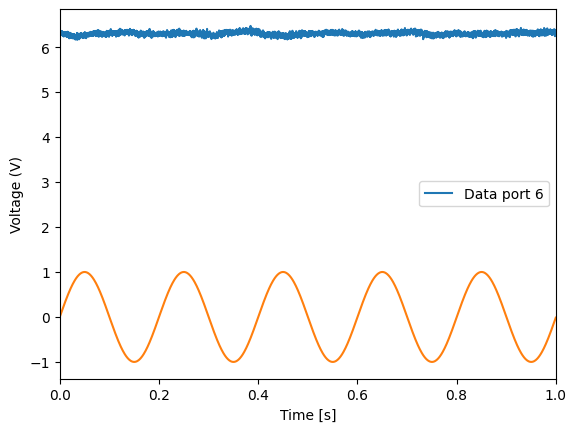

In [ ]:
import time
# open connection
mAI = MultiChannelAnalogInput(lCh, limit,reset = True)
mAI.configure(address, rate, nSample, trigSource, trigSlopePositive, trigLevel)

data = mAI.readAll()

# put data in list of channels
for key, data in data.items():
    indx = lChName.index(key)
    print(indx)
    print('I am waiting during the read', indx)
    lTrace[indx] = data
    if indx in [6]:
        plt.plot(np.linspace(0,dt*nSample,nSample),lTrace[indx], label='Data port %s'%indx)
        plt.legend()
        plt.xlabel('Time [s]')
        plt.ylabel('Voltage (V)')
plt.xlim(0,1)
frequency=5
amplitude=50
Labber_number=643
line_Nr=8
 # 3,5,8
#plt.plot(np.linspace(0,1,1001), np.sin(frequency*2*3.14*np.linspace(0,1,1001)), label='AWG Signal')
mAI.closeAll()
with open('data_freq=%.2lf_amp=%i_LabNumb=%i_line=%i.npy'%(frequency, amplitude, Labber_number, line_Nr), 'wb') as f:
#with open('Testting_line.npy', 'wb') as f:
    np.save(f, lTrace[indx])
    np.save(f, np.linspace(0,dt*nSample,nSample))
plt.savefig("Testting_AWG_port4_blue_cable3_f=%.lfHz; Amp=%imV"%(frequency, amplitude))



[-0.39224935 -0.3600576  -0.39289318 ... -0.36778362 -0.34589322
 -0.323359  ]
[0.00000000e+00 1.00010001e-04 2.00020002e-04 ... 9.99799980e-01
 9.99899990e-01 1.00000000e+00]


20000


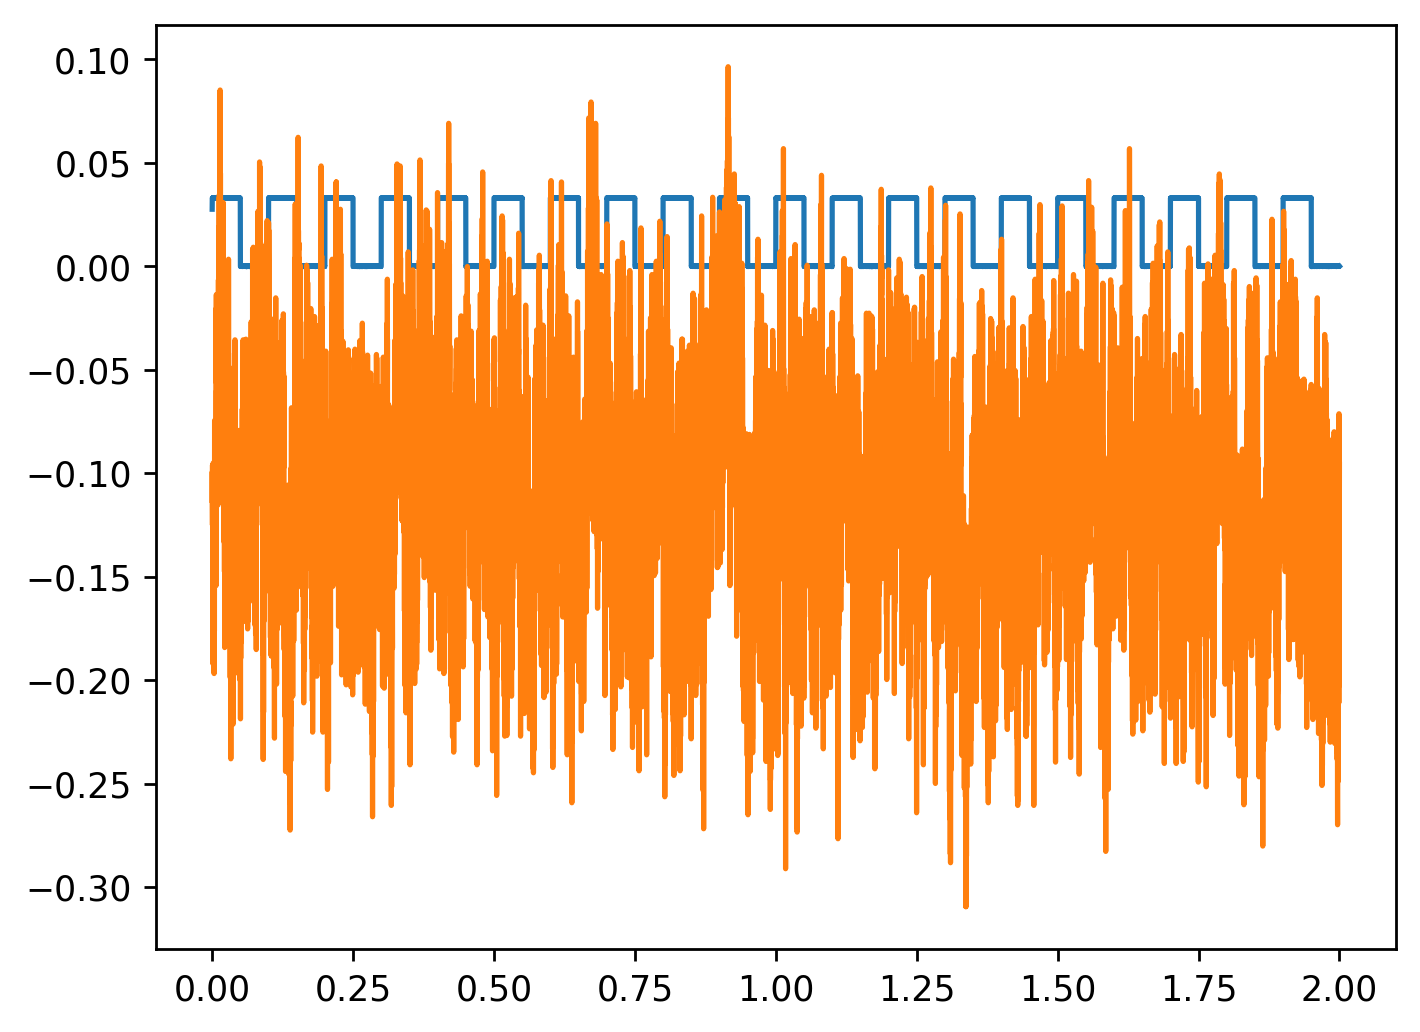

In [20]:
# plt.plot(lTrace[6][0:2000])
print(lTrace[0].size)

trace_reshaped=lTrace[0].reshape(80, 250)
plt.figure(dpi=250)
plt.plot(np.linspace(0,dt*nSample,nSample),lTrace[0]/100)
plt.plot(np.linspace(0,dt*nSample,nSample),lTrace[6])
# plt.plot(trace_reshaped)

### View experiment in pulse sheet viewer

To-do: 
1. Add stability diagram visualization

In [19]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
compiled_exp = session.compiled_experiment
show_pulse_sheet(".\laboneq_output\ST pulse test", compiled_exp)

2023.07.21 18:59:15.843 laboneq.pulse_sheet_viewer.pulse_sheet_viewer INFO   Writing html file to c:\Users\B15measure2\HDAWG\laboneq_output\ST pulse test_2023-07-21-18-59-15.html


c:\Users\B15measure2\HDAWG\laboneq_output\ST pulse test_2023-07-21-18-59-15.html

In [20]:
helpers.interactive_psv(compiled_exp)

# 2D sweep example, wait time vs phase of second pulse

## Experiment

In [ ]:
## constant definition
X90_DURATION = 10e-9  # [s]

START = 0
STOP = 2 * np.pi
STEPS = 5
NUM_REP = 2

START_DELAY = 0
STOP_DELAY = LEN_COULOMB_CYCLE / 2 - 2 * X90_DURATION
STEPS_DELAY = 3


In [ ]:
## define phase sweep parameter
sweep_phase = LinearSweepParameter(
    uid="phase_sweep", start=START, stop=STOP, count=STEPS
)
sweep_delay = LinearSweepParameter(
    uid="Ramsey_delay", start=START_DELAY, stop=STOP_DELAY, count=STEPS_DELAY
)

print(sweep_phase.values / np.pi)

In [ ]:
## Create Experiment
exp = Experiment(
    "Ramsey variant I",
    signals=[
        ExperimentSignal("drive"),
        ExperimentSignal("gate1"),
        ExperimentSignal("gate2"),
    ],
)

# define experiment
with exp.acquire_loop_rt(
    uid="shots", count=NUM_REP, averaging_mode=AveragingMode.CYCLIC
):
    with exp.sweep(uid="sweep_delay", parameter=sweep_delay):
        with exp.sweep(uid="sweep_phase", parameter=sweep_phase):
            with exp.section(
                uid="qubit_excitation",
                alignment=SectionAlignment.RIGHT,
                length=LEN_COULOMB_CYCLE,
            ):
                exp.play(signal="gate1", pulse=coulomb_pulse, amplitude=0.5)
                exp.play(signal="gate1", pulse=coulomb_pulse, amplitude=0.75)

                exp.play(signal="gate2", pulse=coulomb_pulse, amplitude=0.5)
                exp.play(signal="gate2", pulse=coulomb_pulse, amplitude=0.75)

                exp.play(signal="drive", pulse=drive_pulse, set_oscillator_phase=0)
                exp.delay(signal="drive", time=sweep_delay)
                exp.play(
                    signal="drive",
                    pulse=drive_pulse,
                    increment_oscillator_phase=sweep_phase,
                )
            with exp.section(
                uid="qubit_readout",
                alignment=SectionAlignment.RIGHT,
                length=LEN_READOUT,
            ):
                exp.play(signal="gate1", pulse=coulomb_readout, amplitude=0.3)
                exp.play(signal="gate2", pulse=coulomb_readout, amplitude=0.3)
            with exp.section(
                uid="outer_trigger",
                length=LEN_READOUT,
                trigger={"drive": {"state": 1}},
                alignment=SectionAlignment.RIGHT,
            ):
                with exp.section(
                    uid="inner_trigger",
                    length=LEN_READOUT - 100e-9,
                    trigger={"drive": {"state": 2}},
                ):
                    exp.reserve(signal="drive")


In [ ]:
# create and connect to session
session = Session(device_setup=device_setup)
session.connect(do_emulation=DO_EMULATION)

# set experiment calibration and signal map
exp.set_calibration(calib_q0)
exp.set_signal_map(map_q0)

session.run(exp)

## View experiment in pulse sheet viewer

In [ ]:
# use pulse sheet viewer to display the pulse sequence - only recommended for small number of averages and sweep steps to avoid performance issues
compiled_exp = session.compiled_experiment
show_pulse_sheet("2D example", compiled_exp)

